##DATASET

##Installing Kaggle API

In [116]:
!pip install kagglehub
print("Kaggle API Installed")

Kaggle API Installed


In [117]:
from google.colab import files
files.upload()
# This will prompt you to upload your kaggle.json file

#Move the key to the correct location
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [118]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("anashamoutni/students-employability-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/anashamoutni/students-employability-dataset/versions/1


In [119]:
#Verify the download
import os

# List all files in the dataset folder
print(os.listdir(path))


['Student-Employability-Datasets.xlsx']


##Load the Dataset



In [120]:
import pandas as pd
import os

# Full path to the Excel file
excel_file = os.path.join(path, 'Student-Employability-Datasets.xlsx')

# Load the Excel file
data = pd.read_excel(excel_file)

# Preview the data
print(data.head())
print(data.info())

  Name of Student  GENERAL APPEARANCE  MANNER OF SPEAKING  PHYSICAL CONDITION  \
0       Student 1                   4                   5                   4   
1       Student 2                   4                   4                   4   
2       Student 3                   4                   3                   3   
3       Student 4                   3                   3                   3   
4       Student 5                   4                   4                   3   

   MENTAL ALERTNESS  SELF-CONFIDENCE  ABILITY TO PRESENT IDEAS  \
0                 5                5                         5   
1                 4                4                         4   
2                 3                3                         3   
3                 2                3                         3   
4                 3                4                         4   

   COMMUNICATION SKILLS  Student Performance Rating           CLASS  
0                     5                       

##Phase 1 - DATA PROCESSING

##Clean and Normalize the dataset

In [121]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Drop the "Name of Student" column
data_cleaned = data.drop(columns=["Name of Student"])

# Normalize numeric columns (Min-Max Scaling)
scaler = MinMaxScaler()
numeric_columns = [
    "GENERAL APPEARANCE", "MANNER OF SPEAKING", "PHYSICAL CONDITION",
    "MENTAL ALERTNESS", "SELF-CONFIDENCE", "ABILITY TO PRESENT IDEAS",
    "COMMUNICATION SKILLS", "Student Performance Rating"
]
# Create the 'COMMUNICATION_SKILLS_TOTAL' interaction term
data_cleaned['COMMUNICATION_SKILLS_TOTAL'] = (
    data_cleaned['COMMUNICATION SKILLS'] + data_cleaned['ABILITY TO PRESENT IDEAS']
)
# Create the 'CONFIDENCE_ALERTNESS' interaction term
data_cleaned['CONFIDENCE_ALERTNESS'] = (
    data_cleaned['SELF-CONFIDENCE'] * data_cleaned['MENTAL ALERTNESS']
)


data_cleaned[numeric_columns] = scaler.fit_transform(data_cleaned[numeric_columns])

# Encode the "CLASS" column
le = LabelEncoder()
data_cleaned["CLASS"] = le.fit_transform(data_cleaned["CLASS"])

# Preview the cleaned dataset
print(data_cleaned.head())


   GENERAL APPEARANCE  MANNER OF SPEAKING  PHYSICAL CONDITION  \
0            0.666667            1.000000            0.666667   
1            0.666667            0.666667            0.666667   
2            0.666667            0.333333            0.333333   
3            0.333333            0.333333            0.333333   
4            0.666667            0.666667            0.333333   

   MENTAL ALERTNESS  SELF-CONFIDENCE  ABILITY TO PRESENT IDEAS  \
0          1.000000         1.000000                  1.000000   
1          0.666667         0.666667                  0.666667   
2          0.333333         0.333333                  0.333333   
3          0.000000         0.333333                  0.333333   
4          0.333333         0.666667                  0.666667   

   COMMUNICATION SKILLS  Student Performance Rating  CLASS  \
0              1.000000                         1.0      0   
1              0.333333                         1.0      0   
2              0.000000   

##Phase 2 – Feature Engineering


##Check Feature Correlation

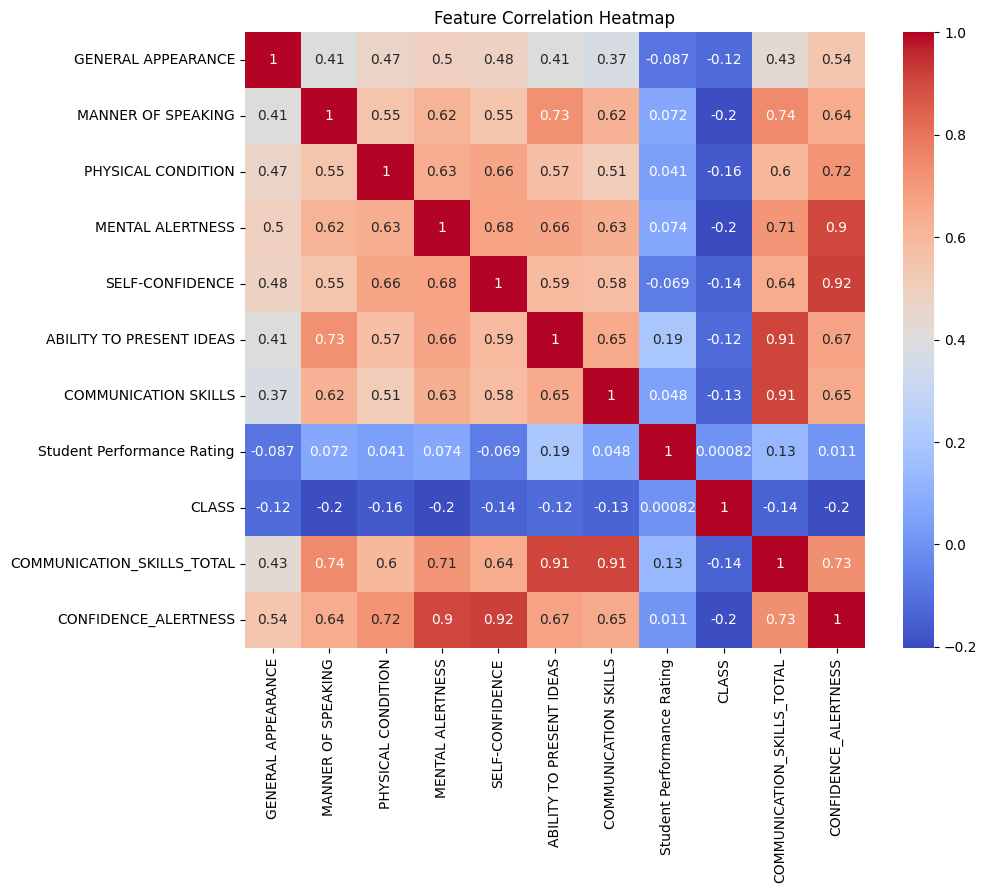

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = data_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##Red/orange: Positive correlation.
##Blue: Negative correlation.
##White/gray: Near zero (no correlation).

##Aggregated Features

In [123]:
# Example: Create a total "communication-related skills" feature
data_cleaned['COMMUNICATION_SKILLS_TOTAL'] = (
    data_cleaned['COMMUNICATION SKILLS'] + data_cleaned['ABILITY TO PRESENT IDEAS']
)
# Printing feature
print("Aggregate Feature: COMMUNICATION_SKILLS_TOTAL")
print(data_cleaned[['COMMUNICATION SKILLS', 'ABILITY TO PRESENT IDEAS', 'COMMUNICATION_SKILLS_TOTAL']].head())

Aggregate Feature: COMMUNICATION_SKILLS_TOTAL
   COMMUNICATION SKILLS  ABILITY TO PRESENT IDEAS  COMMUNICATION_SKILLS_TOTAL
0              1.000000                  1.000000                    2.000000
1              0.333333                  0.666667                    1.000000
2              0.000000                  0.333333                    0.333333
3              0.333333                  0.333333                    0.666667
4              0.333333                  0.666667                    1.000000


##Interaction Terms

In [124]:
# Example: Interaction between self-confidence and mental alertness
data_cleaned['CONFIDENCE_ALERTNESS'] = (
    data_cleaned['SELF-CONFIDENCE'] * data_cleaned['MENTAL ALERTNESS']
)

# Print the updated dataset with the interaction feature
print("Interaction Feature: CONFIDENCE_ALERTNESS")
print(data_cleaned[['SELF-CONFIDENCE', 'MENTAL ALERTNESS', 'CONFIDENCE_ALERTNESS']].head())

Interaction Feature: CONFIDENCE_ALERTNESS
   SELF-CONFIDENCE  MENTAL ALERTNESS  CONFIDENCE_ALERTNESS
0         1.000000          1.000000              1.000000
1         0.666667          0.666667              0.444444
2         0.333333          0.333333              0.111111
3         0.333333          0.000000              0.000000
4         0.666667          0.333333              0.222222


##Polynomial Features

In [125]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data_cleaned[numeric_columns])

# Convert to DataFrame with appropriate column names
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numeric_columns))

# Print the first 5 rows of polynomial features
print("Polynomial Features (Degree 2):")
print(poly_df.head())

# Optionally, add polynomial features back to the original dataset
data_cleaned = pd.concat([data_cleaned, poly_df], axis=1)


Polynomial Features (Degree 2):
   GENERAL APPEARANCE  MANNER OF SPEAKING  PHYSICAL CONDITION  \
0            0.666667            1.000000            0.666667   
1            0.666667            0.666667            0.666667   
2            0.666667            0.333333            0.333333   
3            0.333333            0.333333            0.333333   
4            0.666667            0.666667            0.333333   

   MENTAL ALERTNESS  SELF-CONFIDENCE  ABILITY TO PRESENT IDEAS  \
0          1.000000         1.000000                  1.000000   
1          0.666667         0.666667                  0.666667   
2          0.333333         0.333333                  0.333333   
3          0.000000         0.333333                  0.333333   
4          0.333333         0.666667                  0.666667   

   COMMUNICATION SKILLS  Student Performance Rating  GENERAL APPEARANCE^2  \
0              1.000000                         1.0              0.444444   
1              0.333333   

In [126]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 5 features based on ANOVA F-statistic
X = data_cleaned.drop(columns=['CLASS'])
y = data_cleaned['CLASS']
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

# Update DataFrame with only selected features
data_cleaned = data_cleaned[selected_features.tolist() + ['CLASS']]



Selected Features: Index(['GENERAL APPEARANCE MENTAL ALERTNESS',
       'MANNER OF SPEAKING PHYSICAL CONDITION',
       'MANNER OF SPEAKING MENTAL ALERTNESS',
       'PHYSICAL CONDITION MENTAL ALERTNESS', 'MENTAL ALERTNESS^2'],
      dtype='object')


In [127]:
# Printing features
print(data_cleaned.info())
print(data_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   GENERAL APPEARANCE MENTAL ALERTNESS    2982 non-null   float64
 1   MANNER OF SPEAKING PHYSICAL CONDITION  2982 non-null   float64
 2   MANNER OF SPEAKING MENTAL ALERTNESS    2982 non-null   float64
 3   PHYSICAL CONDITION MENTAL ALERTNESS    2982 non-null   float64
 4   MENTAL ALERTNESS^2                     2982 non-null   float64
 5   CLASS                                  2982 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 139.9 KB
None
   GENERAL APPEARANCE MENTAL ALERTNESS  MANNER OF SPEAKING PHYSICAL CONDITION  \
0                             0.666667                               0.666667   
1                             0.444444                               0.444444   
2                             0.222222            

##Phase 3 – Data Analysis and Visualization

In [128]:
print(data.columns)

Index(['Name of Student', 'GENERAL APPEARANCE', 'MANNER OF SPEAKING',
       'PHYSICAL CONDITION', 'MENTAL ALERTNESS', 'SELF-CONFIDENCE',
       'ABILITY TO PRESENT IDEAS', 'COMMUNICATION SKILLS',
       'Student Performance Rating', 'CLASS'],
      dtype='object')


In [130]:
# Distribution plots for key features
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned['COMMUNICATION_SKILLS_TOTAL'], kde=True, color='blue', bins=30)
plt.title("Distribution of Communication Skills Total")
plt.show()

sns.histplot(data_cleaned['CONFIDENCE_ALERTNESS'], kde=True, color='green', bins=30)
plt.title("Distribution of Confidence and Alertness Interaction")
plt.show()

KeyError: 'COMMUNICATION_SKILLS_TOTAL'

<Figure size 1200x600 with 0 Axes>

In [129]:
# Pairplot to visualize relationships between features
sns.pairplot(data_cleaned[['COMMUNICATION_SKILLS_TOTAL', 'CONFIDENCE_ALERTNESS', 'MENTAL ALERTNESS', 'SELF-CONFIDENCE', 'CLASS']], hue="CLASS")
plt.show()


KeyError: "['COMMUNICATION_SKILLS_TOTAL', 'CONFIDENCE_ALERTNESS', 'MENTAL ALERTNESS', 'SELF-CONFIDENCE'] not in index"

In [ ]:
# Check class distribution
sns.countplot(x='CLASS', data=data_cleaned)
plt.title("Class Distribution")
plt.show()


In [ ]:
# Correlation with the target variable
correlation_with_target = data_cleaned.corr()['CLASS'].sort_values(ascending=False)
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation with Target (CLASS)")
plt.show()


##Phase 4 – Model Building


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into features (X) and target (y)
X = data_cleaned.drop(columns=['CLASS'])
y = data_cleaned['CLASS']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# 3. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)



# Print the results
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Print classification reports for further evaluation
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

# Confusion Matrices
print("\nDecision Tree Confusion Matrix:")
print(confusion_matrix(y_test, dt_predictions))

print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))


In [ ]:
import joblib

# Save the trained RandomForest model
joblib.dump(rf_model, 'random_forest_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')

##Adding Evaluation Metrics in a Table

In [ ]:
import pandas as pd

# Create a DataFrame with accuracy, precision, recall, F1 score for each model
results = {
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [dt_accuracy, rf_accuracy, lr_accuracy],
    'Precision': [classification_report(y_test, dt_predictions, output_dict=True)['1']['precision'],
                  classification_report(y_test, rf_predictions, output_dict=True)['1']['precision'],
                  classification_report(y_test, lr_predictions, output_dict=True)['1']['precision']],
    'Recall': [classification_report(y_test, dt_predictions, output_dict=True)['1']['recall'],
               classification_report(y_test, rf_predictions, output_dict=True)['1']['recall'],
               classification_report(y_test, lr_predictions, output_dict=True)['1']['recall']],
    'F1 Score': [classification_report(y_test, dt_predictions, output_dict=True)['1']['f1-score'],
                 classification_report(y_test, rf_predictions, output_dict=True)['1']['f1-score'],
                 classification_report(y_test, lr_predictions, output_dict=True)['1']['f1-score']]
}

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


##Phase 5 – Evaluation and Visualization

##Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Decision Tree Cross-Validation
dt_cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
dt_cv_mean = dt_cv_scores.mean()

# Random Forest Cross-Validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
rf_cv_mean = rf_cv_scores.mean()

# Logistic Regression Cross-Validation
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')
lr_cv_mean = lr_cv_scores.mean()

# Display results
print(f"Decision Tree CV Mean Accuracy: {dt_cv_mean:.4f}")
print(f"Random Forest CV Mean Accuracy: {rf_cv_mean:.4f}")
print(f"Logistic Regression CV Mean Accuracy: {lr_cv_mean:.4f}")


##Confusion Matrix Visualization:

In [ ]:
# Confusion Matrix for Decision Tree
dt_cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [ ]:
# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title("Random Forest Confusion Matrix")
plt.show()


In [ ]:
# Confusion Matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title("Logistic Regression Confusion Matrix")
plt.show()

##Plotting Feature Importance (for Tree-Based Models)

In [ ]:
# Feature Importance for Random Forest
feature_importance_rf = rf_model.feature_importances_
sorted_idx_rf = feature_importance_rf.argsort()

plt.figure(figsize=(8, 6))
plt.barh(X.columns[sorted_idx_rf], feature_importance_rf[sorted_idx_rf])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()


In [ ]:
# Feature Importance for Decision Tree
feature_importance_dt = dt_model.feature_importances_
sorted_idx_dt = feature_importance_dt.argsort()

plt.figure(figsize=(8, 6))
plt.barh(X.columns[sorted_idx_dt], feature_importance_dt[sorted_idx_dt])
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance")
plt.show()

##Model Comparison Visualization

In [ ]:
# Model Comparison (Accuracy Bar Chart)
models = ['Decision Tree', 'Random Forest', 'Logistic Regression']
accuracies = [dt_accuracy, rf_accuracy, lr_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.show()


In [ ]:
# For Decision Tree: Get predicted probabilities
dt_predictions_prob = dt_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# For Random Forest: Get predicted probabilities
rf_predictions_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# For Logistic Regression: Get predicted probabilities
lr_predictions_prob = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1


# ROC Curve for Decision Tree
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_predictions_prob)
dt_auc = auc(dt_fpr, dt_tpr)

plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ROC Curve for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_predictions_prob)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ROC Curve for Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_predictions_prob)
lr_auc = auc(lr_fpr, lr_tpr)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Step 1: Select the two features for model training
X_2D_train = data_cleaned[['COMMUNICATION_SKILLS_TOTAL', 'CONFIDENCE_ALERTNESS']]
y_2D_train = data_cleaned['CLASS']

# Step 2: Train the Decision Tree and Random Forest models using only these two features
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the models
dt_model_2D = DecisionTreeClassifier(random_state=42)
rf_model_2D = RandomForestClassifier(random_state=42)

# Train the models
dt_model_2D.fit(X_2D_train, y_2D_train)
rf_model_2D.fit(X_2D_train, y_2D_train)

# Step 3: Plot decision boundaries for both models using the plot_decision_boundary function

# Plot decision boundary for Decision Tree
plot_decision_boundary(dt_model_2D, X_2D_train, y_2D_train, "Decision Tree Decision Boundary")

# Plot decision boundary for Random Forest
plot_decision_boundary(rf_model_2D, X_2D_train, y_2D_train, "Random Forest Decision Boundary")


##Phase 6 – Prototype Development

##Install Streamlit

In [ ]:
!pip install streamlit
print("\nstreamlit installed successfully")

In [ ]:
import joblib

# Load the trained model, scaler, and label encoder
rf_model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')
le = joblib.load('label_encoder.pkl')


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load pre-trained model and scalers
rf_model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')
le = joblib.load('label_encoder.pkl')

# Streamlit App Layout
st.title("Student Employability Prediction")
st.write("This application predicts employability class based on communication skills and confidence.")

# Input fields for the features (two features used for this example)
communication_skills = st.slider("Communication Skills Total", min_value=0.0, max_value=1.0, value=0.5, step=0.01)
confidence_alertness = st.slider("Confidence and Alertness", min_value=0.0, max_value=1.0, value=0.5, step=0.01)

# Prediction button
if st.button('Predict'):
    # Create a DataFrame from the user input
    user_data = pd.DataFrame([[communication_skills, confidence_alertness]], columns=['COMMUNICATION_SKILLS_TOTAL', 'CONFIDENCE_ALERTNESS'])

    # Scale the data (ensure you use the same scaler as when you trained the model)
    user_data_scaled = scaler.transform(user_data)

    # Make prediction with your trained model
    prediction = rf_model.predict(user_data_scaled)

    # Decode the prediction back to original label if necessary
    prediction_class = le.inverse_transform(prediction)

    # Display the result
    st.write(f"Predicted Class: {prediction_class[0]}")
